In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pint, os
ureg = pint.UnitRegistry()

In [9]:
T = 300 * ureg.kelvin
kB =  1.380649e-23 * ureg.joule/ureg.kelvin # J/K
Na = 6.022141e23/ureg.mol # mol-1
h = 6.626e-34 * ureg.joule*ureg.second # Js
mass_CO2_g_mol = 44.01 * ureg.gram/ureg.mol
mass_CO2 = mass_CO2_g_mol / Na
mass_CO2 = mass_CO2.to_base_units()
deBroglie_wavelength = np.sqrt(h**2/(2*np.pi*mass_CO2*kB*T)).to_base_units()

In [10]:
# Theory
def density_from_mu_id(mu_K, deBroglie_wavelength, kB, T):
    mu_J = (mu_K*kB).to_base_units()
    return np.exp(-mu_J/(kB*T)) / deBroglie_wavelength**3

# Directory scanner
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

def measure_isotherm(dirs, atoms = ["CO2"], data_type = "density"):
    out_data = []
    for dir in dirs:
        mean_out = 0
        for atom in atoms:
            if data_type == "density":
                out = np.loadtxt(dir+"/density_"+atom+".dat")[:,1]
            elif data_type == "pressure":
                out = np.loadtxt(dir+"/density_"+atom+".dat")[:,1]
            N_end = len(out)//50
            mean_out += np.mean(out[-N_end:])
        out_data.append(mean_out)
    out_data = np.array(out_data)
    if data_type == "density":
        out_data *= ureg.gram/ureg.centimeter**3
    elif data_type == "pressure":
        out_data *= ureg.atm
    return out_data

# Folder detector
def scan_directory(dir_lammps):
    subfolders= fast_scandir("./")
    filtered_subfolders = []
    for dir in subfolders:
        if "outputs_" in dir:
            if dir_lammps:
                if "lammps-comparison" in dir:
                    filtered_subfolders.append(dir)
            else:
                if "lammps" not in dir:
                    filtered_subfolders.append(dir) 
    chemical_potentials_K = []
    for dir in filtered_subfolders:
        mu_K = np.float32(dir.split("_")[-1][2:])
        chemical_potentials_K.append(mu_K)
    chemical_potentials_K = np.array(chemical_potentials_K)
    chemical_potentials_K = chemical_potentials_K *ureg.degree_Kelvin
    return filtered_subfolders, chemical_potentials_K

# LAMMPS data

In [11]:
lammps_dir, lammps_mu_K = scan_directory(dir_lammps = True)
lammps_rho_g_cm3 = measure_isotherm(lammps_dir, atoms = ["CO2"], data_type = "density")
lammps_p_atm = measure_isotherm(lammps_dir, atoms = ["CO2"], data_type = "pressure")

# GOMC data

In [12]:
gomc_dir, gomc_mu_K = scan_directory(dir_lammps = False)
gomc_rho_g_cm3 = measure_isotherm(gomc_dir, atoms = ["C", "O"], data_type = "density")
gomc_p_atm = measure_isotherm(gomc_dir, atoms = ["C", "O"], data_type = "pressure")

# Theory

In [13]:
mu_K = np.arange(2500, 5500)*ureg.kelvin
rho_m3 = density_from_mu_id(mu_K, deBroglie_wavelength, kB, T) # per m3
rho_g_cm3 = (rho_m3 * mass_CO2_g_mol / Na).to(ureg.gram/ureg.cm**3)

# Plot

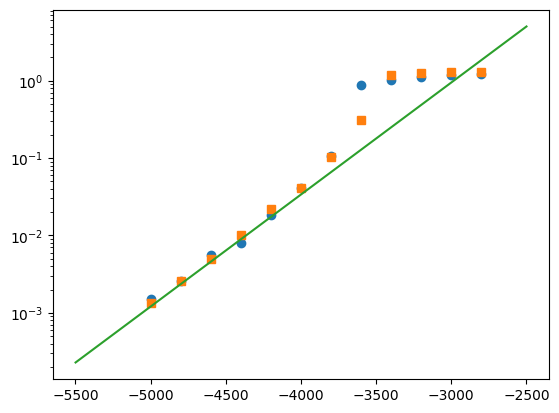

In [14]:
plt.semilogy(-gomc_mu_K.magnitude, gomc_rho_g_cm3.magnitude, 'o')
plt.semilogy(-lammps_mu_K.magnitude, lammps_rho_g_cm3.magnitude, 's')
plt.semilogy(-mu_K.magnitude, rho_g_cm3.magnitude)